In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models
from netam.common import pick_device, parameter_count_of_model
from netam.framework import load_shmoof_dataframes

In [ ]:
shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nickname = 'small'

site_count=500
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [ ]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 1000

In [ ]:
train_dataset_3, val_dataset_3 = data_of_nickname(val_nickname, kmer_length=3)
train_dataset_5, val_dataset_5 = data_of_nickname(val_nickname, kmer_length=5)

val_data_by_kmer_length = {
    3: val_dataset_3,
    5: val_dataset_5,
}
 
model_instances_3 = {
    "cnn_sml": models.CNNModel(kmer_length=3, embedding_dim=6, filter_count=14, kernel_size=7, dropout_rate=0.0),
    "cnn_med": models.CNNModel(kmer_length=3, embedding_dim=9, filter_count=9, kernel_size=11, dropout_rate=0.1),
    "cnn_lrg": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=19, kernel_size=11, dropout_rate=0.3),
    "cnn_4k": models.CNNModel(kmer_length=3, embedding_dim=12, filter_count=14, kernel_size=17, dropout_rate=0.1),
    "cnn_8k": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_rate=0.0),
    }

model_instances_5 = {
    "fivemer": models.FivemerModel(kmer_length=5),
    "shmoof": models.SHMoofModel(kmer_length=5, site_count=site_count),
}

In [ ]:
tang_df = pd.read_csv("/Users/matsen/data/tang-deepshm_size2_edges_22-May-2023.branch_length.csv", index_col=0).reset_index(drop=True)

# only keep rows where parent is different than child
tang_df = tang_df[tang_df["parent"] != tang_df["child"]]
tang_dataset_3 = framework.SHMoofDataset(tang_df, kmer_length=3, site_count=site_count)
tang_dataset_5 = framework.SHMoofDataset(tang_df, kmer_length=5, site_count=site_count)

tang_data_by_kmer_length = {
    3: tang_dataset_3,
    5: tang_dataset_5,
}

In [ ]:
def train_or_load(model_name, model_instance, train_dataset, val_dataset):
    crepe_prefix = f"../pretrained/{model_name}"
    best_val_loss = None

    if framework.does_crepe_exist(crepe_prefix):
        print(f"\tLoading pre-trained {model_name}...")
        crepe = framework.load_crepe(crepe_prefix)
        assert crepe.model.hyperparameters == model_instance.hyperparameters
        return crepe.model

    # else:
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model_instance.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    train_history = burrito.train(epochs=epochs)
    # save model to pretrained/ directory
    Path("../pretrained").mkdir(parents=True, exist_ok=True)
    burrito.save_crepe(crepe_prefix)

    return model_instance

In [ ]:
def train_and_summarize(model_instances, train_dataset, val_dataset):
    summary_list = []

    for model_name, model in model_instances.items():
        model = train_or_load(model_name, model, train_dataset, val_dataset)
        summary_list.append({
            'model_name': model_name, 
            'model': model, 
            'parameter_count': parameter_count_of_model(model),
            'kmer_length': model.kmer_length,
        })

    return pd.DataFrame(summary_list)

In [ ]:
comparison_df = \
    pd.concat([ train_and_summarize(model_instances_3, train_dataset_3, val_dataset_3),
                train_and_summarize(model_instances_5, train_dataset_5, val_dataset_5)
            ])
comparison_df["val_nickname"] = val_nickname

comparison_df
    

	Loading pre-trained cnn_sml...
	Loading pre-trained cnn_med...
	Loading pre-trained cnn_lrg...
	Loading pre-trained cnn_4k...
	Loading pre-trained cnn_8k...
	Loading pre-trained fivemer...
	Loading pre-trained shmoof...


,model_name,model,parameter_count,kmer_length,val_nickname
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,3,small
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,3,small
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,3,small
3,cnn_4k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",3665,3,small
4,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,3,small
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,5,small
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,5,small


In [ ]:
def calculate_loss(model, dataset):
    model.eval()
    model.to(device)
    dataset.to(device)
    burrito = framework.Burrito(dataset, dataset, model, verbose=False, **burrito_params)
    loss = burrito.evaluate()
    return loss

def loss_of_dataset_dict(dataset_dict):
    return [
        calculate_loss(row["model"], dataset_dict[row["kmer_length"]])
        for _, row in comparison_df.iterrows()
    ]

comparison_df["val_loss"] = loss_of_dataset_dict(val_data_by_kmer_length)
comparison_df["tang_loss"] = loss_of_dataset_dict(tang_data_by_kmer_length)

In [ ]:
comparison_df

,model_name,model,parameter_count,kmer_length,val_nickname,val_loss,tang_loss
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,3,small,0.055606,0.089671
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,3,small,0.055451,0.089609
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,3,small,0.055389,0.089357
3,cnn_4k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",3665,3,small,0.055386,0.089764
4,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,3,small,0.055567,0.090053
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,5,small,0.055738,0.089919
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,5,small,0.055603,0.090088


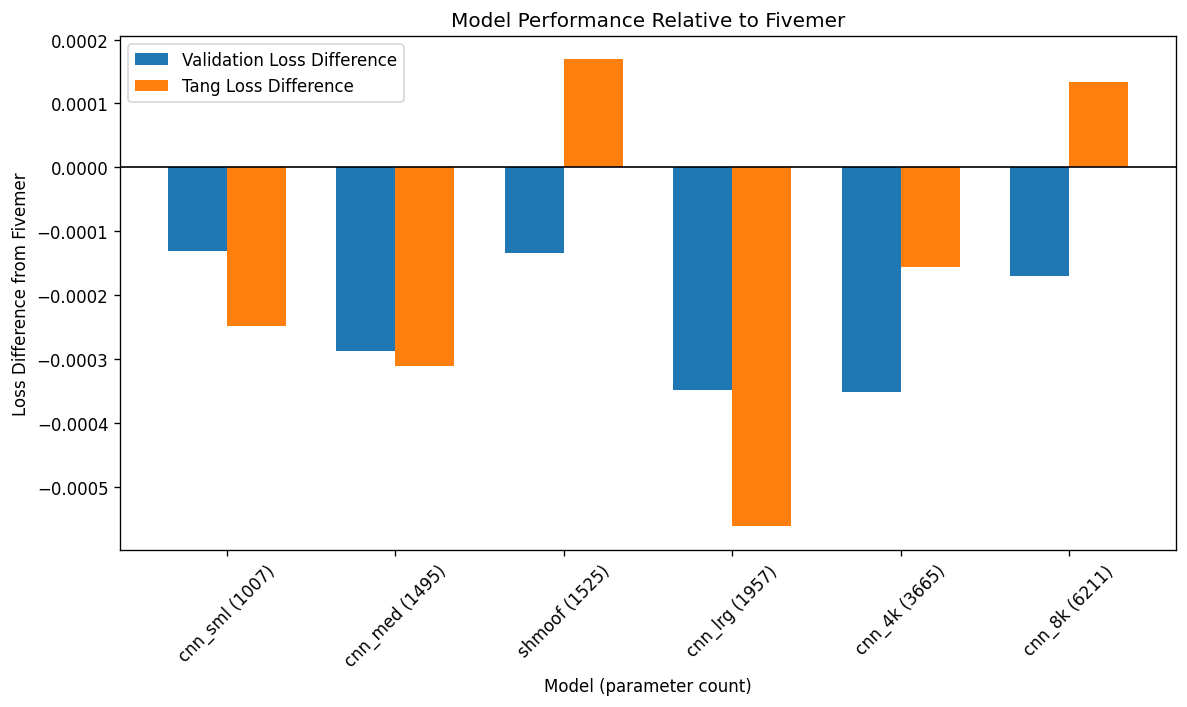

In [ ]:
df = comparison_df

# Calculate the difference from the fivemer model for val_loss and tang_loss
fivemer_val_loss = df[df['model_name'] == 'fivemer']['val_loss'].values[0]
fivemer_tang_loss = df[df['model_name'] == 'fivemer']['tang_loss'].values[0]

df['val_loss_diff'] = df['val_loss'] - fivemer_val_loss
df['tang_loss_diff'] = df['tang_loss'] - fivemer_tang_loss

# Filter out the fivemer model and sort by parameter count
df = df[df['model_name'] != 'fivemer']
df = df.sort_values(by='parameter_count')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(df))

# Creating offset for the second bar
offset = bar_width / 2

bar1 = ax.bar(index - offset, df['val_loss_diff'], bar_width, label='Validation Loss Difference')
bar2 = ax.bar(index + offset, df['tang_loss_diff'], bar_width, label='Tang Loss Difference')

ax.set_xlabel('Model (parameter count)')
ax.set_ylabel('Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.legend()
ax.axhline(0, color='black', linewidth=1)  # Add x-axis line

# Format x-axis labels with model names and parameter counts
x_labels = [f"{row['model_name']} ({row['parameter_count']})" for _, row in df.iterrows()]
plt.xticks(index, x_labels, rotation=45)

plt.tight_layout()
plt.show()